In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model

# Body-Only Model

## X

In [2]:
df = pd.read_csv('data/processed/data_with_stem_lem.csv', index_col='Id')

In [3]:
df.fillna('code', inplace=True)

In [4]:
vocab_size = 73_747 # From 03-WordAnalysis.ipynb

token = Tokenizer(num_words=vocab_size,
                  filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                  lower=True
                 )

token.fit_on_texts(df['Body'].values)
X = token.texts_to_sequences(df['Body'].values)
len(token.word_index)

114067

In [5]:
len(X)

60000

In [6]:
max_words_in_post = 150
# This number could be tweaked (look at histogram of word count per class)
padded_X = pad_sequences(X, maxlen = max_words_in_post, padding = 'post')

In [7]:
print(padded_X.shape, ' ', padded_X, sep='\n')

(60000, 150)
 
[[   6  225 2264 ...    0    0    0]
 [ 106  662    2 ...    0    0    0]
 [ 319    2  135 ...    0    0    0]
 ...
 [1749  519    1 ...    0    0    0]
 [ 492  178   86 ...    0    0    0]
 [ 744 2500  182 ...    0    0    0]]


## y

In [8]:
y = pd.get_dummies(df['Y']).values

In [9]:
print(y.shape,' ', y, sep='\n')

(60000, 3)
 
[[0 1 0]
 [0 0 1]
 [1 0 0]
 ...
 [0 0 1]
 [0 1 0]
 [0 1 0]]


## Train Test Split

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 42
                                                   )

In [11]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(48000, 150) (48000, 3)
(12000, 150) (12000, 3)


## Creating the Model

In [12]:
model = Sequential()
model.add(Embedding(vocab_size+1, max_words_in_post, input_length=X_train.shape[1], mask_zero=True))
model.add(SpatialDropout1D(0.3))
model.add(GRU(75, dropout=0.2))
model.add(Dense(Y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['categorical_accuracy']
             )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 150)          11062200  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 150, 150)          0         
_________________________________________________________________
gru (GRU)                    (None, 75)                51075     
_________________________________________________________________
dense (Dense)                (None, 3)                 228       
Total params: 11,113,503
Trainable params: 11,113,503
Non-trainable params: 0
_________________________________________________________________


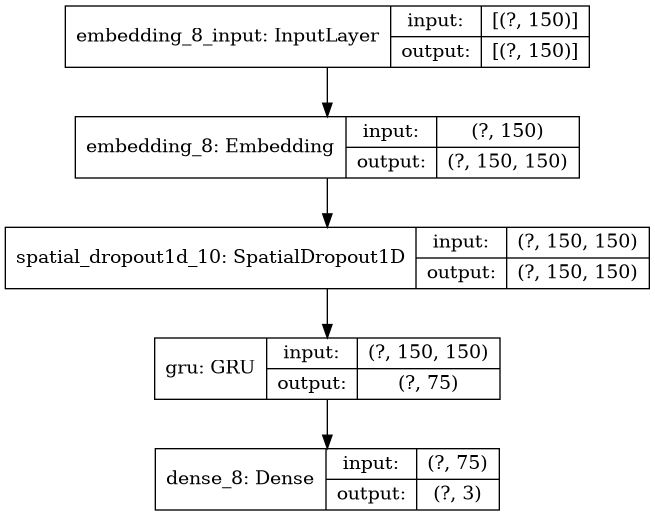

In [32]:
# plot_model(loaded, to_file='data/img/BodyOnlyModel.png',show_shapes=True)

## Training the model (on Google Colab)

I have exported the training step to a google colab gpu runtime to speed up the process. I have tried several sequential neural networks:
* Embedding - SpatialDropout1D - LSTM - Dense
* Embedding - SpatialDropout1D - LSTM - SpatialDropout1D - LSTM - Dense
* Embedding - SpatialDropout1D - GRU - Dense

The fitting parameters stayed the same for all models, but the layers parameters changed between the iterations. A couple of layers did not see much variation:
* The embedding layer (input layer) with an input size of 73748 (the vocabulary +1), an output size of 100 or 150 (maximum words in a question) and the `zero_mask=` flag on (the training stage is faster with this option 'on'; from about 8 epochs to about 4 for the same model parameters)
* The final dense layer (output layer) used a "softmax" activation, and had 3 nodes (for the 3 grades of questions).

The best model (in terms of categorical_accuracy) is the GRU, reaching 0.9179. The LSTM is right behind with a categorical_accuracy of 0.9143. The training times are comparable.

In [14]:
# history = model.fit(X_train,
#                     Y_train,
#                     epochs=20,
#                     validation_split=0.1,
#                     callbacks=[EarlyStopping(monitor='val_loss',
#                                              min_delta=0.0001,
#                                              patience=3,
#                                              verbose=1,
#                                              mode='min',
#                                              restore_best_weights=True
#                                              ),
#                             #    ModelCheckpoint(filepath='drive/My Drive/Colab Notebooks/Model/Checkpoints/epoch-{epoch:03d}.ckpt', 
#                             #                    verbose=1
#                             #                    )
#                               ]
#                    )

## Model metrics

In [15]:
# plt.title('Loss')
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='val')
# plt.legend()
# plt.show();

In [16]:
# plt.title('Accuracy')
# plt.plot(history.history['accuracy'], label='train')
# plt.plot(history.history['val_accuracy'], label='val')
# plt.legend()
# plt.show();

## Saving the model

In [17]:
# model.save('data/model//')

## Loading the model

In [25]:
loaded = keras.models.load_model('data/model/embGRU/')

## Evaluation

In [26]:
evaluation = loaded.evaluate(X_test,Y_test)
print(f'Test set:\n\
          Loss: {evaluation[0]:0.3f}\n\
          Accuracy: {evaluation[1]:0.3f}'
     )

375/375 [==============================] - 7s 17ms/step - loss: 0.5289 - categorical_accuracy: 0.7902
Test set:
          Loss: 0.529
          Accuracy: 0.790


## Prediction

In [29]:
# Questions from the website (might be in the dataset, need to check)
# HQ score = 25042, ID = 11227809
# LQ_CLOSE = -26, ID = 24681866
# LQ_EDIT = 9, ID = 3977535
hq_question = """Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data miraculously makes the code almost six times faster: code Without std::sort(data, data + arraySize);, the code runs in 11.54 seconds. With the sorted data, the code runs in 1.93 seconds. Initially, I thought this might be just a language or compiler anomaly, so I tried Java: code  With a similar but less extreme result. My first thought was that sorting brings the data into the cache, but then I thought how silly that was because the array was just generated. What is going on? Why is processing a sorted array faster than processing an unsorted array? The code is summing up some independent terms, so the order should not matter."""
lq_close_question = """My html code is code How I convert it into wordpress menu? Actually I want include in wordpress menu title="features" data-hover="Features" """
lq_edit_question = """I have two different timeseries with partially overlapping timestamps: code which represents following data: code I would like to calculate a weighted average on every day with coefficients a(0.3) and b(0.7), while ignoring missing values: code when I first try to align these timeseries: code I get correctly masked timeseries: code but when I do a1 * 0.3 + b1 * 0.7, it ignores values, that are present in one timeseries only: code What should I do to receive the awaited? code EDIT: The answer should be applicable also to more than two initial timeseries with different weights and differently missing values. o if we have four timeseries with weights T1(0.1), T2(0.2), T3(0.3) and T4(0.4), their weights at a given timestamp will be: code"""
questions = [hq_question, lq_edit_question, lq_close_question]

for i in questions:
    sequenced = token.texts_to_sequences(i.split())
    padded = pad_sequences(sequenced, maxlen=max_words_in_post, padding='post')
    prediction = loaded.predict(padded)
    labels = pd.get_dummies(df['Y']).columns
    print(prediction[1], labels[np.argmax(prediction[1])], sep='\n')

[0.23417658 0.5232507  0.2425727 ]
LQ_CLOSE
[0.28383532 0.48139757 0.23476705]
LQ_CLOSE
[0.18974414 0.4045494  0.40570644]
LQ_EDIT


In [31]:
import numpy as np
for i in df.sample(5).index:
    sequenced = token.texts_to_sequences(df['Body'].loc[i].split())
    padded = pad_sequences(sequenced, maxlen=max_words_in_post, padding='post')
    prediction = loaded.predict(padded)
    labels = pd.get_dummies(df['Y']).columns
    print(f"Predicted:{labels[np.argmax(prediction[1])]}\n     Real:{df['Y'].loc[i]}\n")

Predicted:LQ_EDIT
     Real:LQ_CLOSE

Predicted:LQ_CLOSE
     Real:HQ

Predicted:LQ_EDIT
     Real:LQ_CLOSE

Predicted:HQ
     Real:HQ

Predicted:LQ_CLOSE
     Real:LQ_CLOSE

